Import Libraries

In [1]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax.config import config
from flax import linen as nn

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
jax.config.update("jax_enable_x64", True)

In [2]:
n_gpu = len(jax.devices())
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0)]

General PDE form:

    𝜕𝑢/𝜕𝑡 + [𝛼+𝛽𝑢]𝜕𝑢/𝜕𝑥 − 𝛾(𝜕𝑥^2𝑢)/(𝜕𝑥^2) + 𝛿(𝜕𝑥^3𝑢)/(𝜕𝑥^3) = 𝑞(𝑥,𝑡)

        1. Heat equation (𝛼,𝛽,𝛾,𝛿) = (0,0,𝛾,0)
        2. Convection-diffusion equation (𝛼,𝛽,𝛾,𝛿) = (1,0,𝛾,0)
        3. Burgers’ equation (𝛼,𝛽,𝛾,𝛿) = (0,1,𝛾,0)
        4. KDV equation (𝛼,𝛽,𝛾,𝛿) = (0,1,0,𝛿)

    IC : 𝑢(𝑥,0) = 𝑞(𝑥,0)
    Periodic BC : 𝑥∈[0,𝐿]

In [3]:
# spatial domain
x_l, x_u = 0.0, 1.0
x_d = x_u - x_l # domain length

# time domain: 0 - t_T (only use half of the domain!)
t_T = 2.0

# split x_train into PDE, IC & BC
x_train = jnp.load(os.path.join('data_meta_pdes', 'cds_input.npy'))
_ic, _bc = (x_train[:,1] == 0), (x_train[:,0] == x_l) #| (x_train[:,0] == x_u) # periodic BC - only query x_l
data_pde, data_ic, data_bc = x_train[~(_ic|_bc)], x_train[_ic], x_train[_bc & ~_ic]
batch_data_pde, batch_data_ic, batch_data_bc = data_pde, data_ic, data_bc
print (batch_data_pde.shape, batch_data_ic.shape, batch_data_bc.shape)

(5000, 2) (101, 2) (50, 2)


In [4]:
# expand time domain
ex_train = x_train[(x_train[:,1] > 0) & (x_train[:,1] <= 1)]
ex_train = ex_train + jnp.array([0, 2])
ex_train = jnp.vstack([x_train, ex_train])
e_ic, e_bc = (ex_train[:,1] == 0), (ex_train[:,0] == x_l) #| (x_train[:,0] == x_u) # periodic BC - only query x_l
edata_pde, edata_ic, edata_bc = ex_train[~(e_ic|e_bc)], ex_train[e_ic], ex_train[e_bc & ~e_ic]
ebatch_data_pde, ebatch_data_ic, ebatch_data_bc = edata_pde, edata_ic, edata_bc
print (ebatch_data_pde.shape, ebatch_data_ic.shape, ebatch_data_bc.shape)

(7500, 2) (101, 2) (75, 2)


In [5]:
# reduced time domain
rx_train = x_train[x_train[:,1] <= 1]
r_ic, r_bc = (rx_train[:,1] == 0), (rx_train[:,0] == x_l) #| (x_train[:,0] == x_u) # periodic BC - only query x_l
rdata_pde, rdata_ic, rdata_bc = rx_train[~(r_ic|r_bc)], rx_train[r_ic], rx_train[r_bc & ~r_ic]
rbatch_data_pde, rbatch_data_ic, rbatch_data_bc = rdata_pde, rdata_ic, rdata_bc
print (rbatch_data_pde.shape, rbatch_data_ic.shape, rbatch_data_bc.shape)

(2500, 2) (101, 2) (25, 2)


In [6]:
print (x_train.shape, ex_train.shape, rx_train.shape)

(5151, 2) (7676, 2) (2626, 2)


Define source function - q(x, t)

In [7]:
# coef.
@jit
def sample_coef(rng):
    # generate random sample
    key, rng = random.split(rng) # update random generator
    Ajs = round(random.uniform(key, shape=(J,), minval=-.8, maxval=.8), 2)
    key, rng = random.split(rng) # update random generator
    wjs = round(random.uniform(key, shape=(J,), minval=-2, maxval=2), 2)
    key, rng = random.split(rng) # update random generator
    ljs = round(random.choice(key, jnp.array([0,1,2,3,4]), shape=(J,)), 2)
    key, rng = random.split(rng) # update random generator
    pjs = round(random.uniform(key, shape=(J,), minval=-jnp.pi, maxval=jnp.pi), 2)
    return (Ajs, wjs, ljs, pjs)

# q(x,t)
@jit
def q_xt(x, t, coefs):
    # coef.
    Ajs, wjs, ljs, pjs = coefs
    # obtain q
    q = jnp.zeros_like(x)
    for i in range(J):
        q = q + Ajs[i] * jnp.sin(wjs[i]*t + (2*jnp.pi*ljs[i]*x)/L + pjs[i])
    return q


# hyper-parameter
J = 5
L = 1

Baldwinian PINN (B-PINN)

In [8]:
# construct randomization B-PINN for linear/nonlinear ODE/PDEs
@jit
def get_f(x, t, weights):
    f = jnp.hstack([jnp.sin((x-.5) * weights[0] + t * weights[1] + weights[2]),
                    nn.softplus((x-.5) * weights[3] + t * weights[4] + weights[5]),
                    jnp.tanh((x-.5) * weights[6] + t * weights[7] + weights[8]),
                    jnp.sin((x-.5) * weights[9] + t * weights[10] + weights[11]),
                    nn.softplus((x-.5) * weights[12] + t * weights[13] + weights[14]),
                    jnp.tanh((x-.5) * weights[15] + t * weights[16] + weights[17])])
    return f

# obtain f_t
def get_f_t(get_f, x, t, weights):
    f_t = jacfwd(get_f, argnums=1)(x, t, weights)
    return f_t

# obtain f_x
def get_f_x(get_f, x, t, weights):
    f_x = jacfwd(get_f)(x, t, weights)
    return f_x

#obtain f_xx
def get_f_xx(get_f, x, t, weights):
    f_xx = jacfwd(jacfwd(get_f))(x, t, weights)
    return f_xx

# obtain f_xxx
def get_f_xxx(get_f, x, t, weights):
    f_xxx = jacfwd(jacfwd(jacfwd(get_f)))(x, t, weights)
    return f_xxx

f_t_vmap = vmap(get_f_t, in_axes=(None, 0, 0, None))
f_x_vmap = vmap(get_f_x, in_axes=(None, 0, 0, None))
f_xx_vmap = vmap(get_f_xx, in_axes=(None, 0, 0, None))
f_xxx_vmap = vmap(get_f_xxx, in_axes=(None, 0, 0, None))

Least square problem

In [9]:
# no. neurons
n_node = 200

# generate weight & bias dist.
seed = 1
key, rng = random.split(random.PRNGKey(seed))
key, rng = random.split(rng) # update random generator
weights_n = random.truncated_normal(key, shape=(n_node, 9), lower=-1, upper=1)
key, rng = random.split(rng) # update random generator
weights_u = random.uniform(key, (n_node, 9), minval=-1, maxval=1)

# regularization
lamb = 1e-4

In [10]:
# compute hidden node outputs / derivaties & construct least square problem
@jit
def compute_ls_task(param, task, task_all):
    # generate weight & bias dist. (given param)
    weights = jnp.hstack([weights_n* param[:9] + param[9:18], weights_u* param[18:27] + param[27:-1]]).T
    # generate coefs (given task)
    t_ic, t_para, alpha, beta, gamma, delta = task_all[task]
    t_ic = t_ic.astype(int)
    coefs = sample_coef(random.split(random.PRNGKey(t_ic))[1])
    # populate PDE sub-matrix given sample
    x, t = jnp.array_split(batch_data_pde, 2, axis=1)
    f_t = f_t_vmap(get_f, x, t, weights)[:,:,0]
    f_x = f_x_vmap(get_f, x, t, weights)[:,:,0]
    f_xx = f_xx_vmap(get_f, x, t, weights)[:,:,0,0]
    f_xxx = f_xxx_vmap(get_f, x, t, weights)[:,:,0,0,0]
    # PDE: u_t + (alpha + beta*u)*u_x - gamma*u_xx + delta*u_xxx = q(x,t)
    f_pde = f_t + alpha*f_x - gamma*f_xx + delta*f_xxx
    r_pde = q_xt(x, t, coefs)
    # populate BC sub-matrix given sample (x, t)
    x, t = jnp.array_split(batch_data_bc, 2, axis=1)
    f_bc = get_f(x, t , weights) - get_f(x + x_d, t , weights) # enforce periodic BC
    r_bc = jnp.zeros((f_bc.shape[0], 1))
    # populate IC sub-matrix given sample (x, t)
    x, t = jnp.array_split(batch_data_ic, 2, axis=1)
    f_ic = get_f(x, t, weights)
    r_ic = q_xt(x, t, coefs)
    # construct least square problem
    A = jnp.vstack([f_pde, f_bc, f_ic])
    b = jnp.vstack([r_pde, r_bc, r_ic])
    # alternative solve (n_sample >> n_node)
    reg = lamb *param[-1]
    w = jnp.linalg.inv(reg*jnp.eye(A.shape[1]) + (A.T@A))@A.T@b
    ssr = np.sum((b - A @ w)**2)
    return w, ssr, weights

In [11]:
# apply B-PINNs on new time frame: learning prediction 1-shot (0-3s)
@jit
def compute_ls_task_1(param, task, task_all):
    # generate weight & bias dist. (given param)
    weights = jnp.hstack([weights_n* param[:9] + param[9:18], weights_u* param[18:27] + param[27:-1]]).T
    # generate coefs (given task)
    t_ic, t_para, alpha, beta, gamma, delta = task_all[task]
    t_ic = t_ic.astype(int)
    coefs = sample_coef(random.split(random.PRNGKey(t_ic))[1])
    # populate PDE sub-matrix given sample
    x, t = jnp.array_split(ebatch_data_pde, 2, axis=1)
    f_t = f_t_vmap(get_f, x, t, weights)[:,:,0]
    f_x = f_x_vmap(get_f, x, t, weights)[:,:,0]
    f_xx = f_xx_vmap(get_f, x, t, weights)[:,:,0,0]
    f_xxx = f_xxx_vmap(get_f, x, t, weights)[:,:,0,0,0]
    # PDE: u_t + (alpha + beta*u)*u_x - gamma*u_xx + delta*u_xxx = q(x,t)
    f_pde = f_t + alpha*f_x - gamma*f_xx + delta*f_xxx
    r_pde = q_xt(x, t, coefs)
    # populate BC sub-matrix given sample (x, t)
    x, t = jnp.array_split(ebatch_data_bc, 2, axis=1)
    f_bc = get_f(x, t , weights) - get_f(x + x_d, t , weights) # enforce periodic BC
    r_bc = jnp.zeros((f_bc.shape[0], 1))
    # populate IC sub-matrix given sample (x, t)
    x, t = jnp.array_split(ebatch_data_ic, 2, axis=1)
    f_ic = get_f(x, t, weights)
    r_ic = q_xt(x, t, coefs)
    # construct least square problem
    A = jnp.vstack([f_pde, f_bc, f_ic])
    b = jnp.vstack([r_pde, r_bc, r_ic])
    # alternative solve (n_sample >> n_node)
    reg = lamb *param[-1]
    w = jnp.linalg.inv(reg*jnp.eye(A.shape[1]) + (A.T@A))@A.T@b
    ssr = np.sum((b - A @ w)**2)
    return w, ssr, weights

In [12]:
# apply B-PINNs on new time frame: learning prediction from (0-2 -> 2-4s)
@jit
def compute_ls_task_2(param, task, task_all, r_ic):
    # generate weight & bias dist. (given param)
    weights = jnp.hstack([weights_n* param[:9] + param[9:18], weights_u* param[18:27] + param[27:-1]]).T
    # generate coefs (given task)
    t_ic, t_para, alpha, beta, gamma, delta = task_all[task]
    t_ic = t_ic.astype(int)
    coefs = sample_coef(random.split(random.PRNGKey(t_ic))[1])
    # populate PDE sub-matrix given sample
    x, t = jnp.array_split(batch_data_pde, 2, axis=1)
    f_t = f_t_vmap(get_f, x, t, weights)[:,:,0]
    f_x = f_x_vmap(get_f, x, t, weights)[:,:,0]
    f_xx = f_xx_vmap(get_f, x, t, weights)[:,:,0,0]
    f_xxx = f_xxx_vmap(get_f, x, t, weights)[:,:,0,0,0]
    # PDE: u_t + (alpha + beta*u)*u_x - gamma*u_xx + delta*u_xxx = q(x,t)
    f_pde = f_t + alpha*f_x - gamma*f_xx + delta*f_xxx
    r_pde = q_xt(x, t + 2., coefs)
    # populate BC sub-matrix given sample (x, t)
    x, t = jnp.array_split(batch_data_bc, 2, axis=1)
    f_bc = get_f(x, t , weights) - get_f(x + x_d, t , weights) # enforce periodic BC
    r_bc = jnp.zeros((f_bc.shape[0], 1))
    # populate IC sub-matrix given sample (x, t)
    x, t = jnp.array_split(batch_data_ic, 2, axis=1)
    f_ic = get_f(x, t, weights)
    # construct least square problem
    A = jnp.vstack([f_pde, f_bc, f_ic])
    b = jnp.vstack([r_pde, r_bc, r_ic])
    # alternative solve (n_sample >> n_node)
    reg = lamb *param[-1]
    w = jnp.linalg.inv(reg*jnp.eye(A.shape[1]) + (A.T@A))@A.T@b
    ssr = np.sum((b - A @ w)**2)
    return w, ssr, weights

In [13]:
# apply B-PINNs on new time frame: learning prediction from (0-2 -> 2-3s)
@jit
def compute_ls_task_3(param, task, task_all, r_ic):
    # generate weight & bias dist. (given param)
    weights = jnp.hstack([weights_n* param[:9] + param[9:18], weights_u* param[18:27] + param[27:-1]]).T
    # generate coefs (given task)
    t_ic, t_para, alpha, beta, gamma, delta = task_all[task]
    t_ic = t_ic.astype(int)
    coefs = sample_coef(random.split(random.PRNGKey(t_ic))[1])
    # populate PDE sub-matrix given sample
    x, t = jnp.array_split(rbatch_data_pde, 2, axis=1)
    f_t = f_t_vmap(get_f, x, t, weights)[:,:,0]
    f_x = f_x_vmap(get_f, x, t, weights)[:,:,0]
    f_xx = f_xx_vmap(get_f, x, t, weights)[:,:,0,0]
    f_xxx = f_xxx_vmap(get_f, x, t, weights)[:,:,0,0,0]
    # PDE: u_t + (alpha + beta*u)*u_x - gamma*u_xx + delta*u_xxx = q(x,t)
    f_pde = f_t + alpha*f_x - gamma*f_xx + delta*f_xxx
    r_pde = q_xt(x, t + 2., coefs)
    # populate BC sub-matrix given sample (x, t)
    x, t = jnp.array_split(rbatch_data_bc, 2, axis=1)
    f_bc = get_f(x, t , weights) - get_f(x + x_d, t , weights) # enforce periodic BC
    r_bc = jnp.zeros((f_bc.shape[0], 1))
    # populate IC sub-matrix given sample (x, t)
    x, t = jnp.array_split(rbatch_data_ic, 2, axis=1)
    f_ic = get_f(x, t, weights)
    # construct least square problem
    A = jnp.vstack([f_pde, f_bc, f_ic])
    b = jnp.vstack([r_pde, r_bc, r_ic])
    # alternative solve (n_sample >> n_node)
    reg = lamb *param[-1]
    w = jnp.linalg.inv(reg*jnp.eye(A.shape[1]) + (A.T@A))@A.T@b
    ssr = np.sum((b - A @ w)**2)
    return w, ssr, weights

In [14]:
# solution
def get_u(x, t, weights):
    f = get_f(x, t, weights)
    return (f @ w)

In [15]:
node, stdev, seed = 1200, 5, 1
best_params = jnp.load(os.path.join('model_meta_pdes',
                                    'cds_ssrmse_sigmureg_evobest_w%d_stdev%.1f_seed-%02d.npy'%(node, stdev, seed)))
param = best_params
param

DeviceArray([ 7.39666161e+00, -1.60114372e+01, -2.06785804e+01,
              1.76049996e+01,  8.51754992e+00, -1.20336953e+01,
             -2.04211160e+01,  4.57475021e+00, -1.45929844e+00,
              1.25340898e+01, -1.09585141e+01, -4.99467803e+01,
             -4.79885638e-01, -1.67582993e+01,  1.08705669e+01,
              1.07217185e+01,  2.04309275e+01, -2.22964789e+01,
              2.71557078e-04, -4.22479196e+01,  2.72331440e+01,
              1.46436347e+01,  3.79293837e+01,  2.28009593e+01,
             -1.73060055e+01,  3.02292140e+00,  8.41328634e-01,
             -2.51256693e+01,  1.30770700e+01,  1.26241360e+01,
              2.51571009e+01, -2.66116707e+01, -2.89989421e-01,
              1.41600037e+01,  6.98822747e+00, -1.27721170e+01,
              3.49901433e+01], dtype=float64)

Test linear PDEs problem - unseen PDE, seen & unseen IC (S1 -> S2)

In [16]:
# unseen PDE, seen & unseen IC
case_all = jnp.array([[1, 1, 0, 0.0003, 0.0003],
                      [2, 1, 0, 0.0008, 0.0003],
                      [3, 1, 0, 0.0003, 0.0008],
                      [4, 1, 0, 0.0008, 0.0008]])
seed_all = jnp.arange(15)  # IC
ntask_pde = jnp.hstack([jnp.repeat(seed_all, repeats=len(case_all)).reshape(-1, 1),
                        jnp.tile(case_all, (len(seed_all),1))])
n_task = len(ntask_pde)
print ('no. tasks = %d\n%s'%(n_task, ntask_pde[:5]))

# load data
y_pde = jnp.load(os.path.join('data_meta_pdes', 'cds_test_label_pde.npy'))
y_pde_t2 = jnp.load(os.path.join('data_meta_pdes', 'cds_test_label_pde_t2.npy'))
print (x_train.shape, y_pde.shape, y_pde_t2.shape)

no. tasks = 60
[[0.e+00 1.e+00 1.e+00 0.e+00 3.e-04 3.e-04]
 [0.e+00 2.e+00 1.e+00 0.e+00 8.e-04 3.e-04]
 [0.e+00 3.e+00 1.e+00 0.e+00 3.e-04 8.e-04]
 [0.e+00 4.e+00 1.e+00 0.e+00 8.e-04 8.e-04]
 [1.e+00 1.e+00 1.e+00 0.e+00 3.e-04 3.e-04]]
(5151, 2) (60, 5151, 1) (60, 5151, 1)


Test linear PDEs problem - unseen IC & source term (S1 -> S2)

In [17]:
# unseen IC & source term
case_all = jnp.array([[1, 1, 0, 0.001 , 0.001],
                      [2, 1, 0, 0.0005, 0.001],
                      [3, 1, 0, 0     , 0.001],
                      [4, 1, 0, 0.001 , 0.0005],
                      [5, 1, 0, 0.0005, 0.0005],
                      [6, 1, 0, 0     , 0.0005],
                      [7, 1, 0, 0.001 , 0],
                      [8, 1, 0, 0.0005, 0],
                      [9, 1, 0, 0     , 0]])
seed_all = jnp.arange(9, 12)  # IC
ntask_ic = jnp.hstack([jnp.repeat(seed_all, repeats=len(case_all)).reshape(-1, 1),
                        jnp.tile(case_all, (len(seed_all),1))])
n_task = len(ntask_ic)
print ('no. tasks = %d\n%s'%(n_task, ntask_ic[:5]))

# load data
y_ic = jnp.load(os.path.join('data_meta_pdes', 'cds_test_label_ic.npy'))
y_ic_t2 = jnp.load(os.path.join('data_meta_pdes', 'cds_test_label_ic_t2.npy'))
print (x_train.shape, y_ic.shape, y_ic_t2.shape)

no. tasks = 27
[[9.e+00 1.e+00 1.e+00 0.e+00 1.e-03 1.e-03]
 [9.e+00 2.e+00 1.e+00 0.e+00 5.e-04 1.e-03]
 [9.e+00 3.e+00 1.e+00 0.e+00 0.e+00 1.e-03]
 [9.e+00 4.e+00 1.e+00 0.e+00 1.e-03 5.e-04]
 [9.e+00 5.e+00 1.e+00 0.e+00 5.e-04 5.e-04]]
(5151, 2) (27, 5151, 1) (27, 5151, 1)


Combine both test scenarios

In [18]:
# combine data
ntask_all = jnp.vstack([ntask_pde, ntask_ic])
n_task = len(ntask_all)
print ('no. tasks = %d\n%s'%(n_task, ntask_all[:5]))

y_test = jnp.vstack([y_pde, y_ic])
y_test_t2 = jnp.vstack([y_pde_t2, y_ic_t2])
print (x_train.shape, y_test.shape, y_test_t2.shape)

no. tasks = 87
[[0.e+00 1.e+00 1.e+00 0.e+00 3.e-04 3.e-04]
 [0.e+00 2.e+00 1.e+00 0.e+00 8.e-04 3.e-04]
 [0.e+00 3.e+00 1.e+00 0.e+00 3.e-04 8.e-04]
 [0.e+00 4.e+00 1.e+00 0.e+00 8.e-04 8.e-04]
 [1.e+00 1.e+00 1.e+00 0.e+00 3.e-04 3.e-04]]
(5151, 2) (87, 5151, 1) (87, 5151, 1)


In [19]:
# compute mse
mses = []
for task in range(n_task):
    x, t = jnp.array_split(x_train, 2, axis=1)
    t_ic, t_para, alpha, beta, gamma, delta = ntask_all[task]
    y_train, y_train_t2 = y_test[task], y_test_t2[task]
    y_train = jnp.vstack([y_train, y_train_t2[101:2626]])    
    # learning prediction on first phase (0-2s)
    w, ssr, weights = compute_ls_task(param, task, ntask_all)   
    u = get_u(x, t, weights)
    r_ic = u[(x_train[:,1] == t_T)]
    # P0: prediction on 0-3s via extrapolation
    ex, et = jnp.array_split(ex_train, 2, axis=1)
    u0 = get_u(ex, et, weights)
    mse0 = jnp.mean(jnp.square(y_train - u0))    
    # P1: learning prediction 1-shot (0-3s)
    w, ssr, weights = compute_ls_task_1(param, task, ntask_all)   
    u1 = get_u(ex, et, weights)
    mse1 = jnp.mean(jnp.square(y_train - u1))        
    # P2: learning prediction from (0-2 -> 2-4s)
    w, ssr, weights = compute_ls_task_2(param, task, ntask_all, r_ic)
    u_t2 = get_u(x, t, weights)
    # combine 0-2s & 2-3s
    u2 = jnp.vstack([u, u_t2[101:2626]])
    mse2 = jnp.mean(jnp.square(y_train - u2)) 
    # P3: learning prediction from (0-2 -> 2-3s)
    rx, rt = jnp.array_split(rx_train, 2, axis=1)
    w, ssr, weights = compute_ls_task_3(param, task, ntask_all, r_ic)
    ru_t2 = get_u(rx, rt, weights)
    # combine 0-2s & 2-3s
    u3 = jnp.vstack([u, ru_t2[101:]])
    mse3 = jnp.mean(jnp.square(y_train - u3)) 
    print('%02d [PDE%02d-IC%02d][a=%.0e b=%.0e g=%.0e d=%.0e] | 0-3s: MSE0 = %.1e  MSE1 = %.1e  MSE2 = %.2e  MSE3 = %.2e'%(task,
                                                                                         t_para, t_ic,
                                                                                         alpha, beta, gamma, delta,
                                                                                         mse0, mse1, mse2, mse3));
    mses.append([mse0, mse1, mse2, mse3])

mses = jnp.array(mses)

00 [PDE01-IC00][a=1e+00 b=0e+00 g=3e-04 d=3e-04] | 0-3s: MSE0 = 3.0e-01  MSE1 = 6.7e-04  MSE2 = 6.45e-05  MSE3 = 6.02e-05
01 [PDE02-IC00][a=1e+00 b=0e+00 g=8e-04 d=3e-04] | 0-3s: MSE0 = 1.7e-01  MSE1 = 2.2e-04  MSE2 = 1.62e-05  MSE3 = 1.57e-05
02 [PDE03-IC00][a=1e+00 b=0e+00 g=3e-04 d=8e-04] | 0-3s: MSE0 = 5.1e-02  MSE1 = 1.5e-04  MSE2 = 9.28e-05  MSE3 = 9.05e-05
03 [PDE04-IC00][a=1e+00 b=0e+00 g=8e-04 d=8e-04] | 0-3s: MSE0 = 2.4e-02  MSE1 = 8.8e-05  MSE2 = 3.90e-05  MSE3 = 3.92e-05
04 [PDE01-IC01][a=1e+00 b=0e+00 g=3e-04 d=3e-04] | 0-3s: MSE0 = 1.1e-02  MSE1 = 8.1e-08  MSE2 = 7.35e-08  MSE3 = 8.78e-08
05 [PDE02-IC01][a=1e+00 b=0e+00 g=8e-04 d=3e-04] | 0-3s: MSE0 = 7.8e-03  MSE1 = 9.8e-08  MSE2 = 5.39e-08  MSE3 = 5.77e-08
06 [PDE03-IC01][a=1e+00 b=0e+00 g=3e-04 d=8e-04] | 0-3s: MSE0 = 8.0e-03  MSE1 = 8.0e-07  MSE2 = 1.49e-06  MSE3 = 1.54e-06
07 [PDE04-IC01][a=1e+00 b=0e+00 g=8e-04 d=8e-04] | 0-3s: MSE0 = 7.0e-03  MSE1 = 4.4e-07  MSE2 = 8.16e-07  MSE3 = 7.77e-07
08 [PDE01-IC02][a=1e+00 

68 [PDE09-IC09][a=1e+00 b=0e+00 g=0e+00 d=0e+00] | 0-3s: MSE0 = 5.1e-02  MSE1 = 5.5e-07  MSE2 = 5.53e-07  MSE3 = 4.03e-07
69 [PDE01-IC10][a=1e+00 b=0e+00 g=1e-03 d=1e-03] | 0-3s: MSE0 = 2.5e-03  MSE1 = 8.3e-07  MSE2 = 1.85e-07  MSE3 = 2.06e-07
70 [PDE02-IC10][a=1e+00 b=0e+00 g=5e-04 d=1e-03] | 0-3s: MSE0 = 3.0e-03  MSE1 = 9.7e-07  MSE2 = 3.78e-07  MSE3 = 3.89e-07
71 [PDE03-IC10][a=1e+00 b=0e+00 g=0e+00 d=1e-03] | 0-3s: MSE0 = 4.0e-03  MSE1 = 1.1e-06  MSE2 = 8.28e-07  MSE3 = 8.87e-07
72 [PDE04-IC10][a=1e+00 b=0e+00 g=1e-03 d=5e-04] | 0-3s: MSE0 = 1.4e-03  MSE1 = 8.9e-08  MSE2 = 6.75e-09  MSE3 = 3.89e-09
73 [PDE05-IC10][a=1e+00 b=0e+00 g=5e-04 d=5e-04] | 0-3s: MSE0 = 1.5e-03  MSE1 = 1.2e-07  MSE2 = 5.25e-09  MSE3 = 5.37e-09
74 [PDE06-IC10][a=1e+00 b=0e+00 g=0e+00 d=5e-04] | 0-3s: MSE0 = 1.6e-03  MSE1 = 1.4e-07  MSE2 = 9.10e-09  MSE3 = 1.31e-08
75 [PDE07-IC10][a=1e+00 b=0e+00 g=1e-03 d=0e+00] | 0-3s: MSE0 = 1.4e-03  MSE1 = 2.2e-07  MSE2 = 1.71e-08  MSE3 = 9.33e-09
76 [PDE08-IC10][a=1e+00 

In [20]:
print (mses.mean(axis=0))
print (mses.std(axis=0))

[5.35242238e-02 4.24296148e-05 1.47096324e-05 1.43392662e-05]
[6.08387819e-02 1.03519099e-04 2.32107875e-05 2.22430962e-05]


In [21]:
#jnp.argmax(mses.mean(axis=1)), jnp.argwhere(mses.mean(axis=1) == jnp.percentile(mses.mean(axis=1), 50, interpolation='nearest'))[0][0]

08 [PDE01-IC02][a=1e+00 b=0e+00 g=3e-04 d=3e-04] | 0-3s: MSE0 = 1.0e-01  MSE1 = 7.9e-05  MSE2 = 2.93e-05  MSE3 = 2.77e-05
28 [PDE01-IC07][a=1e+00 b=0e+00 g=3e-04 d=3e-04] | 0-3s: MSE0 = 2.0e-01  MSE1 = 4.0e-04  MSE2 = 7.63e-06  MSE3 = 6.16e-06
80 [PDE03-IC11][a=1e+00 b=0e+00 g=0e+00 d=1e-03] | 0-3s: MSE0 = 2.8e-01  MSE1 = 1.1e-04  MSE2 = 1.13e-04  MSE3 = 9.38e-05


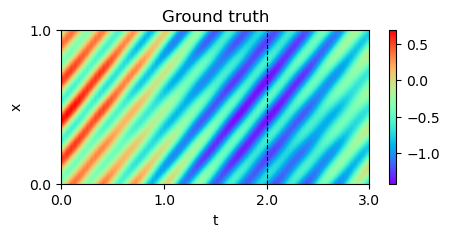

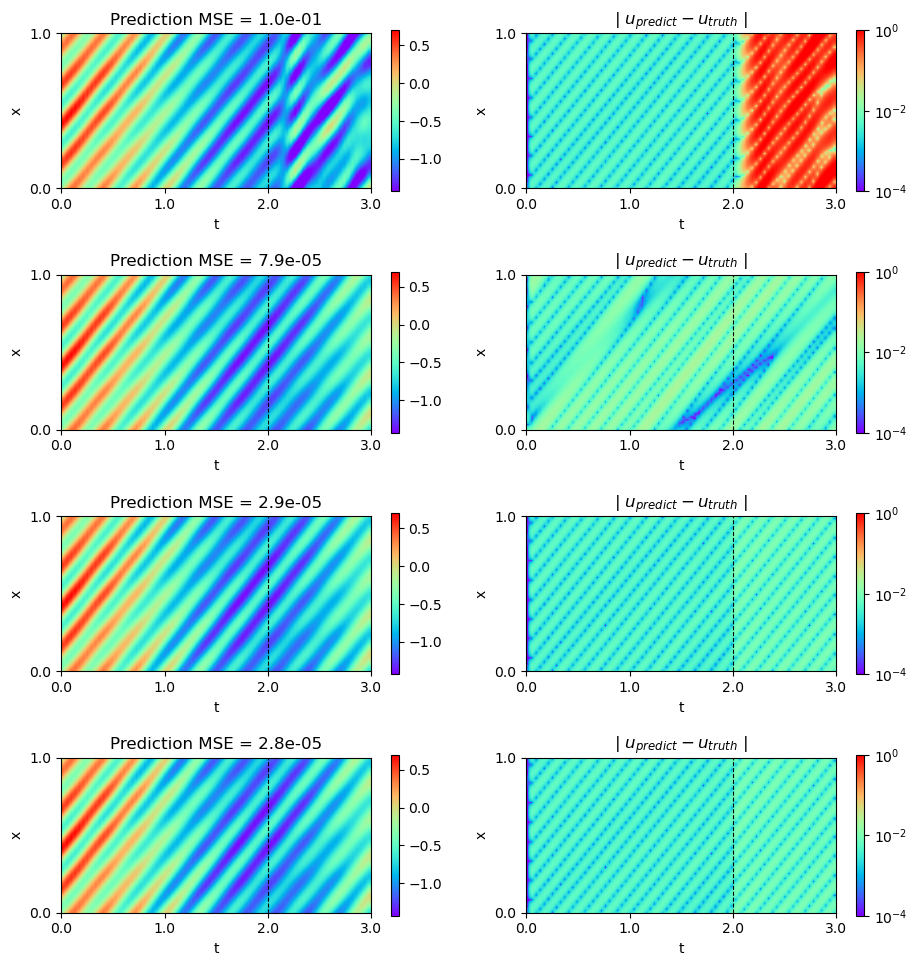

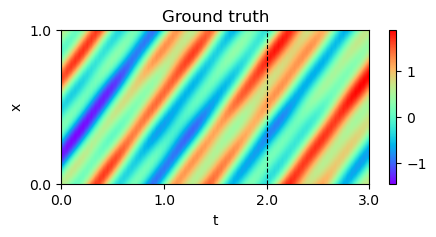

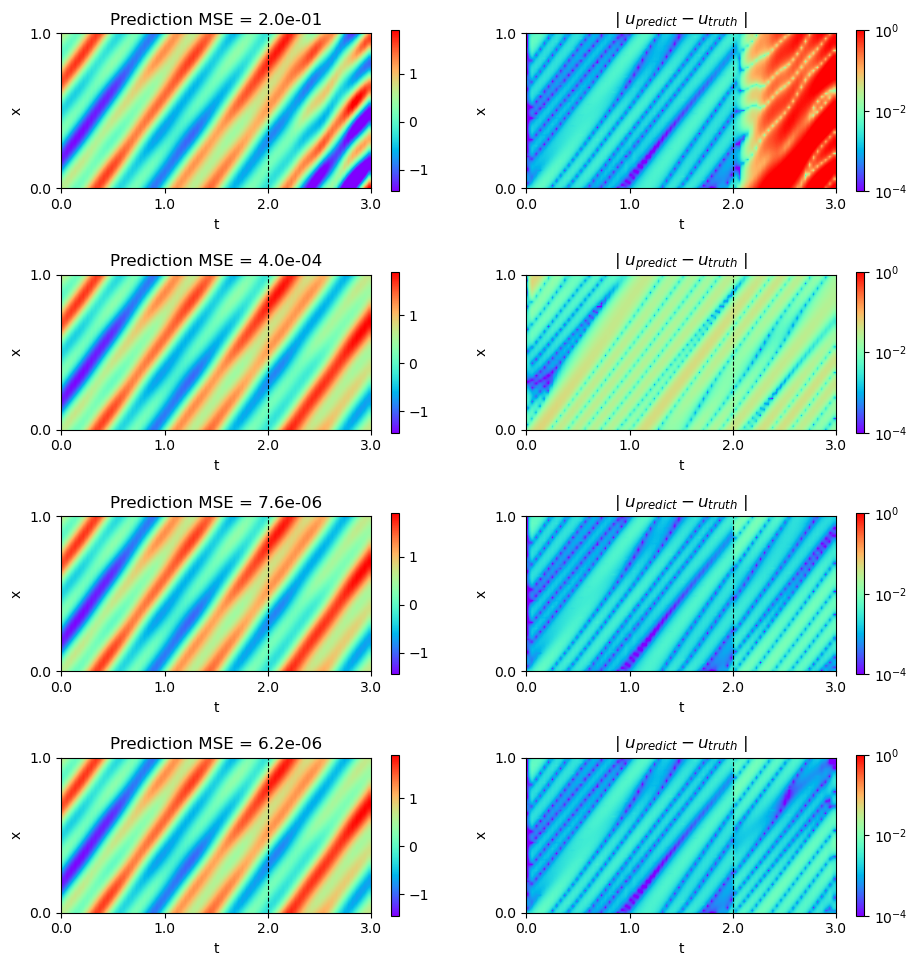

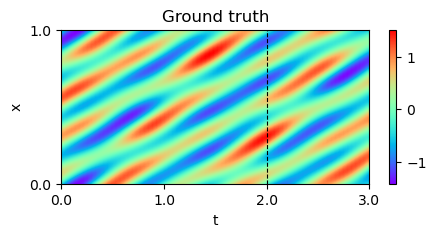

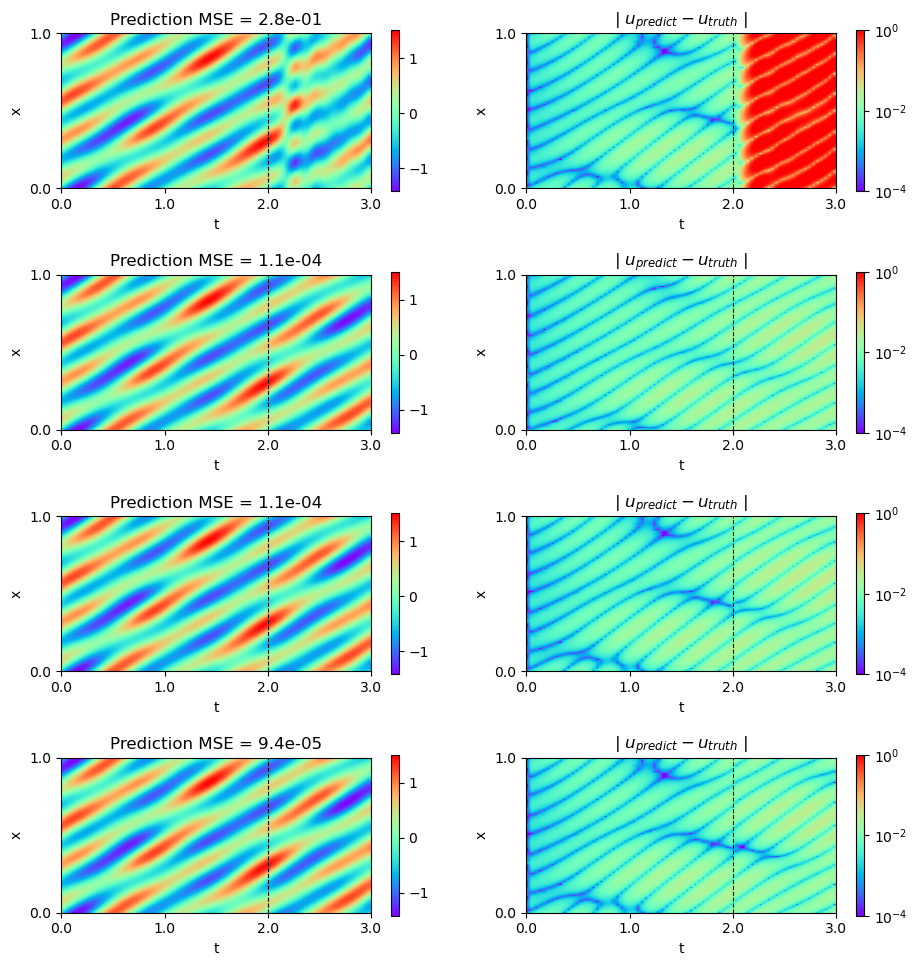

In [22]:
# plot results for selected tasks
for task in [8, 28, 80]:
    x, t = jnp.array_split(x_train, 2, axis=1)
    t_ic, t_para, alpha, beta, gamma, delta = ntask_all[task]
    y_train, y_train_t2 = y_test[task], y_test_t2[task]
    y_train = jnp.vstack([y_train, y_train_t2[101:2626]])    
    # learning prediction on first phase (0-2s)
    w, ssr, weights = compute_ls_task(param, task, ntask_all)   
    u = get_u(x, t, weights)
    r_ic = u[(x_train[:,1] == t_T)]
    # P0: prediction on 0-3s via extrapolation
    ex, et = jnp.array_split(ex_train, 2, axis=1)
    u0 = get_u(ex, et, weights)
    mse0 = jnp.mean(jnp.square(y_train - u0))    
    # P1: learning prediction 1-shot (0-3s)
    w, ssr, weights = compute_ls_task_1(param, task, ntask_all)   
    u1 = get_u(ex, et, weights)
    mse1 = jnp.mean(jnp.square(y_train - u1))        
    # P2: learning prediction from (0-2 -> 2-4s)
    w, ssr, weights = compute_ls_task_2(param, task, ntask_all, r_ic)
    u_t2 = get_u(x, t, weights)
    # combine 0-2s & 2-3s
    u2 = jnp.vstack([u, u_t2[101:2626]])
    mse2 = jnp.mean(jnp.square(y_train - u2)) 
    # P3: learning prediction from (0-2 -> 2-3s)
    rx, rt = jnp.array_split(rx_train, 2, axis=1)
    w, ssr, weights = compute_ls_task_3(param, task, ntask_all, r_ic)
    ru_t2 = get_u(rx, rt, weights)
    # combine 0-2s & 2-3s
    u3 = jnp.vstack([u, ru_t2[101:]])
    mse3 = jnp.mean(jnp.square(y_train - u3)) 
    print('%02d [PDE%02d-IC%02d][a=%.0e b=%.0e g=%.0e d=%.0e] | 0-3s: MSE0 = %.1e  MSE1 = %.1e  MSE2 = %.2e  MSE3 = %.2e'%(task,
                                                                                         t_para, t_ic,
                                                                                         alpha, beta, gamma, delta,
                                                                                         mse0, mse1, mse2, mse3));
    
    # plot ground truth
    fig = plt.figure(figsize=(5, 2))
    #plt.subplots_adjust(wspace=.15)
    ext = [0, 3, x_l, x_u]     # plot boundary
    ax1 = fig.add_subplot(1,1,1)
    u_plot = (y_train.reshape(-1, 101)).T
    mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.5,
                       vmin=y_train.min(), vmax=y_train.max());
    plt.colorbar(mesh2); plt.xlabel('t'); plt.ylabel('x');
    plt.axvline(x=2, linestyle='--', c='k', lw=.8);
    plt.xticks(jnp.linspace(0, 3, 4), jnp.linspace(0, 3, 4)); plt.yticks(jnp.linspace(0, 1, 2), jnp.linspace(0, 1, 2));
    plt.title('Ground truth');    
    # plot prediction
    us = [u0, u1, u2, u3]
    fig = plt.figure(figsize=(11, 11.5))
    plt.subplots_adjust(wspace=.2, hspace=.5) 
    p = 0
    for u in us:
        mse = jnp.mean(jnp.square(y_train - u)) 
        p += 1
        ax1 = fig.add_subplot(4,2,p)
        u_plot = (u.reshape(-1, 101)).T
        mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.5,
                           vmin=y_train.min(), vmax=y_train.max());
        plt.colorbar(mesh2); plt.xlabel('t'); plt.ylabel('x');
        plt.axvline(x=2, linestyle='--', c='k', lw=.8);
        plt.xticks(jnp.linspace(0, 3, 4), jnp.linspace(0, 3, 4)); plt.yticks(jnp.linspace(0, 1, 2), jnp.linspace(0, 1, 2));
        plt.title('Prediction MSE = %.1e'%(mse)); 
        p += 1
        ax1 = fig.add_subplot(4,2,p)
        u_plot = (abs(u - y_train).reshape(-1, 101)).T
        mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.5,
                           norm=colors.LogNorm(vmin=1e-4, vmax=1e0));
        plt.colorbar(mesh2); plt.xlabel('t'); plt.ylabel('x');
        plt.axvline(x=2, linestyle='--', c='k', lw=.8);
        plt.xticks(jnp.linspace(0, 3, 4), jnp.linspace(0, 3, 4)); plt.yticks(jnp.linspace(0, 1, 2), jnp.linspace(0, 1, 2));
        plt.title(r'| $u_{predict} - u_{truth}$ |');  